Last updates

- задача обезразмерена
- на графики добавлены подписи и центр масс
- добавлен контроль $\alpha$ в потенциале $\varphi \propto - 1/r^\alpha$
- добавлены графики в полярных координатах
- добавлен подсчёт и график изменения момента импульса системы
- исправлен баг в подсчёте энергии (G != 1)
- добавлено решение задачи в полярных координатах и графики траекторий для этой задачи
- исправлена ошибка в t_factor

In [18]:
import numpy as np
from matplotlib import pyplot as plt

### Задача Коши

Задача Коши формулируется в виде

$$
\begin{aligned}
\boldsymbol{y}'(\boldsymbol{x}) &= \boldsymbol{f}(\boldsymbol{x}), \quad t \in (0, T]
\\ \boldsymbol{x}(0) &= \boldsymbol{x}_0
\end{aligned}
$$

In [19]:
class CauchyProblem:
    """
    Задача Коши вида
    
    y'(x) = f(x), t in (0, T]
    x(0) = x0
    
    - x0: vector -- начальное условие
    - f: function -- вектор-функция вида f(x: vector) -> vector.
    """

    def __init__(self, x0, f, T):
        # f(vector) -> vector
        self.x0 = x0
        self.f = f
        self.T = T

### Вычислительные методы

In [20]:
# def solver(cauchy_problem, method, h):
#     ...

In [21]:
def rk4(cauchy_problem, h):
    "Классический (явный) метод Рунге-Кутты 4-го порядка."
    
    # allx - матрица, где i-ая строка это решение на временном слое i
    # 0: x1(0) x2(0) x3(0) x4(0)
    # 1: x1(1) x2(1) x3(1) x4(1)
    #    ...
    # i: x1(i) x2(i) x3(i) x4(i), time = i * h
    
    x = np.copy(cauchy_problem.x0)
    steps = int(cauchy_problem.T / h)
    allx = np.copy(x)
    
    for i in range(1, steps + 1):
        k1 = cauchy_problem.f(x)
        k2 = cauchy_problem.f(x + h/2 * k1)
        k3 = cauchy_problem.f(x + h/2 * k2)
        k4 = cauchy_problem.f(x + h * k3)
        
        x += h * (k1/6 + k2/3 + k3/3 + k4/6)
        
        allx = np.vstack([allx, x])
    return allx

In [22]:
def midpoint(cauchy_problem, h):
    "Метод средней точки."
    
    x = np.copy(cauchy_problem.x0)
    steps = int(cauchy_problem.T / h)
    allx = np.copy(x)
    
    for i in range(1, steps + 1):
        x += h * cauchy_problem.f(x + h/2 * cauchy_problem.f(x))
        allx = np.vstack([allx, x])
    return allx

In [23]:
def method38(cauchy_problem, h):
    "Метод 3/8."
    
    x = np.copy(cauchy_problem.x0)
    steps = int(cauchy_problem.T / h)
    allx = np.copy(x)
    
    for i in range(1, steps + 1):
        k1 = cauchy_problem.f(x)
        k2 = cauchy_problem.f(x + h/3 * k1)
        k3 = cauchy_problem.f(x - h/3 * k1 + h * k2)
        k4 = cauchy_problem.f(x + h * k1 - h * k2 + h * k3)
        
        x += h * (k1 + 3*k2 + 3*k3 + k4) / 8
        
        allx = np.vstack([allx, x])
    return allx

### Гравитационная задача

In [24]:
class SatelliteProblem:
    """
    Задача плоского движения спутника в гравитацинном поле с постоянной `G`
    вокруг неподвижной массы `M` в начале координат.

    Известно начальное положение спутника `r0` и начальная скорость `u0`.
    
    Время движения спутника `T`.
    """
    
    def __init__(self, r0, u0, T, G=1, M=1, alpha=1):
        self.r0 = np.array(r0, dtype=np.float64)
        self.u0 = np.array(u0, dtype=np.float64)
        self.T = T
        self.G = G
        self.M = M
        self.alpha = alpha
        
        # Факторы для обезразмеривания
        # Слева размерные величины, справа фактор * обезразмеренная величина
        # t [с] = (GM/x0^3)^(-1/2) * tdimless
        # r [м] = rx0 * rdimless
        # u [м/с] = (GM/x0)^(1/2) * udimless
        self.t_factor = np.sqrt(self.r0[0]**3 / (self.G * self.M))
        self.r_factor = self.r0[0]
        self.u_factor = np.sqrt(self.G * self.M / self.r0[0])
    
    def get_cauchy(self):
        """
        Создаёт обезразмеренную задачу Коши.
        Вектор неизвестных: [Rx, Ux, Ry, Uy].
        """
        x0 = np.array([
            self.r0[0] / self.r_factor,  # X
            self.u0[0] / self.u_factor,  # Ux
            self.r0[1] / self.r_factor,  # Y
            self.u0[1] / self.u_factor   # Uy
        ])
        f = self._get_cauchy_f()
        problem = CauchyProblem(x0, f, self.T)
        return problem

    def _get_cauchy_f(self):
        "Правая часть для задачи Коши. f(x) = [Ux, ACCx, Uy, ACCy]."

        def closure(x):
            alpha = self.alpha
            
            r = np.array([x[0], x[2]])
            norm = np.linalg.norm(r, 2)
            acc = - (r / norm) * (alpha / norm**(alpha + 1))

            return np.array([x[1], acc[0], x[3], acc[1]])
        return closure
    
    def scale_back(self, X):
        unscaled = np.copy(X)
        unscaled[:, 0] *= self.r_factor
        unscaled[:, 2] *= self.r_factor
        unscaled[:, 1] *= self.u_factor
        unscaled[:, 3] *= self.u_factor
        return unscaled
    
    def get_cauchy_polar(self):
        assert self.r0[1] == 0 
        
        r = np.linalg.norm(self.r0)  # sqrt(x^2 + y^2)
        phi = np.arctan(self.r0[1] / self.r0[0])   # atan(y / x)
        
        # Скорость, только для y0 = 0
        rd = self.u0[0]          # ux
        phid = self.u0[1] / r  # uy / r
        
        q0 = np.array([
            r / self.r_factor,
            rd / self.u_factor,
            phi,
            phid * self.t_factor,
        ])
        
        f = self._get_cauchy_f_polar()
        return CauchyProblem(q0, f, self.T)
    
    def _get_cauchy_f_polar(self):
        def closure(q):
            r, rd, phid = q[0], q[1], q[3]
            accr = - self.alpha / r**(self.alpha + 1) + r * phid**2
            accphi = - 2 * rd * phid / r
            return np.array([rd, accr, phid, accphi])
        return closure

### Пример решения задачи

In [25]:
def plot_trajectory(solution, title=""):
    x = solution[:, 0]
    y = solution[:, 2]
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    fig = plt.figure(figsize=(8, 4))
    fig.suptitle(title)

    axd = fig.add_subplot(121)
    axd.set_xlabel("X")
    axd.set_ylabel("Y")
    axd.plot(x, y, label="Траектория")
    axd.plot(0, 0, 'ro', label="Центр притяжения")

    axp = fig.add_subplot(122, polar=True)
    axp.plot(theta, r, label="Траектория")
    axp.plot(0, 0, 'ro', label="Центр притяжения")
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.2, 1))

In [26]:
# Грав. постоянная                         6.6743e-11
# Масса планеты                            марс 6e23 кг
# Расстояние от спутника до планеты,       фобос-марс 6000 км
# Орбитальная скорость (средняя скорость), фобос 2.14 км/с

x0, y0 = 6000e3, 0
ux0, uy0 = 0, 2.14e3
h = 0.001
M = 6e23
G = 6.6743e-11
problem = SatelliteProblem([x0, y0], [ux0, uy0], T=30, M=M, G=G, alpha=1.2)

cauchy = problem.get_cauchy()

#### Метод Рунге-Кутты 4

In [27]:
solution_rk4 = rk4(cauchy, h) 

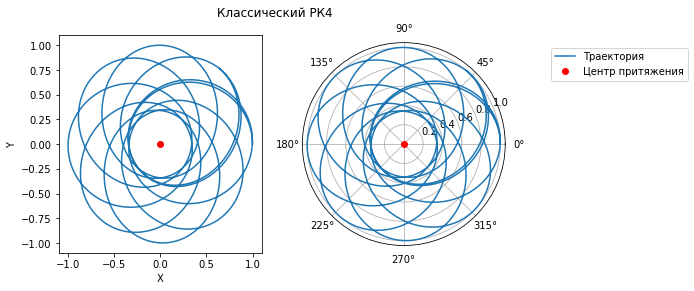

In [28]:
plot_trajectory(solution_rk4, title="Классический РК4")

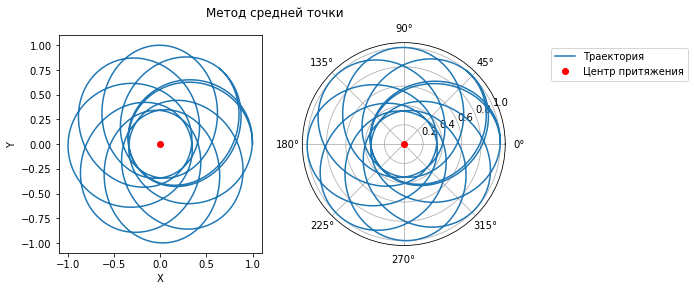

In [29]:
solution_mp = midpoint(cauchy, h)
plot_trajectory(solution_mp, title="Метод средней точки")

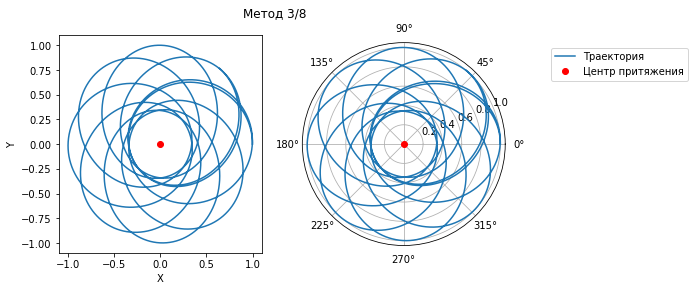

In [30]:
solution_38 = method38(cauchy, h)
plot_trajectory(solution_38, title="Метод 3/8")

Мини-исследования энергии системы. В точной модели полная энергия должна сохраняться. Однако, не все методы обладают этим свойством.

Энергия системы (масса спутника не важна для исследования)

$$
\begin{aligned}
\text{Kinetic}(t) &= \frac{u_x^2(t) + u_y^2(t)}{2}
\\ \text{Potential}(t) &= - \frac{G M}{\|\boldsymbol{r}\|}
\end{aligned}
$$

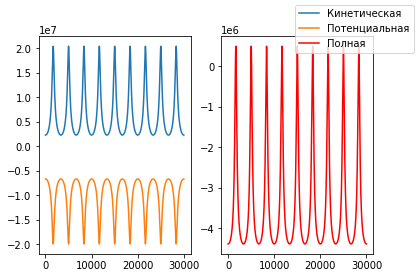

In [31]:
natural_solution_rk4 = problem.scale_back(solution_rk4)
x = natural_solution_rk4[:, 0]
y = natural_solution_rk4[:, 2]
ux = natural_solution_rk4[:, 1]
uy = natural_solution_rk4[:, 3]

kinetic = (ux**2 + uy**2) / 2
potential = - problem.G * problem.M / np.sqrt(x**2 + y**2)
full = kinetic + potential

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(kinetic, label="Кинетическая")
ax1.plot(potential, label="Потенциальная")
ax2.plot(full, "r-", label="Полная")
fig.legend()

Подсчёт и построение момента импульса.

(0.9999999999987685, 1.0000000000012255)

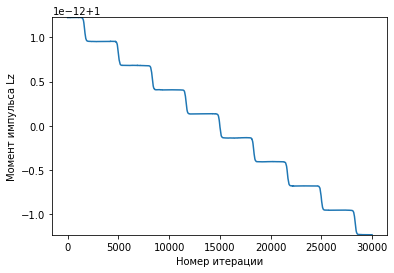

In [32]:
# Переводим решение в СИ.
natural_solution_rk4 = problem.scale_back(solution_rk4)
x = natural_solution_rk4[:, 0]
y = natural_solution_rk4[:, 2]
ux = natural_solution_rk4[:, 1]
uy = natural_solution_rk4[:, 3]

m = 1  # Масса спутника (влияет только на абсолютное значение момента импульса)
# Список из радиус-векторов и список из импульсов спутника.
r = [np.array([xi, yi], dtype=np.float64) for (xi, yi) in zip(x, y)]
p = [np.array([m * uxi, m * uyi], dtype=np.float64) for (uxi, uyi) in zip(ux, uy)] 

# L[i] это z-компонента момента импульса на шаге i.
L = np.cross(r, p)
factor = np.mean(L)  # Для построения в относительных величинах. 1 -- В реальных величинах

plt.xlabel("Номер итерации")
plt.ylabel("Момент импульса Lz")
plt.plot(L / factor)
plt.ylim(np.min(L) / factor, np.max(L) / factor)

## Решение задачи в полярных координатах

In [33]:
cauchy_polar = problem.get_cauchy_polar()
solution_polar_rk4 = rk4(cauchy_polar, h)

x rel error 1.0076820668426769e-07
y rel error 1.1435839122729659e-07


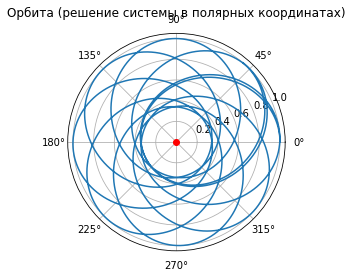

In [34]:
r = solution_polar_rk4[:, 0]
phi = solution_polar_rk4[:, 2]
plt.polar(phi, r)
plt.polar(0, 0, 'ro')
plt.title("Орбита (решение системы в полярных координатах)")

# Сравнение траекторий в декартовых и полярных координатах
x = r * np.cos(phi)
y = r * np.sin(phi)
xdec = solution_rk4[:, 0]
ydec = solution_rk4[:, 2]

# Относительная ошибка определения x
print("x rel error", np.linalg.norm((x - xdec), 2)) #/np.mean(x)
# Относительная ошибка определения y
print("y rel error", np.linalg.norm((y - ydec), 2)) #/np.mean(y)